In [2]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.sparse import hstack
from pymorphy2 import MorphAnalyzer
from matplotlib import pyplot as plt
from sklearn.model_selection import learning_curve, GridSearchCV
from xgboost import XGBClassifier, XGBRegressor
from scipy.stats import normaltest, skew, kurtosis
from sklearn.ensemble import RandomForestRegressor
from scikitplot.estimators import plot_learning_curve
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV, Lasso, Ridge

warnings.filterwarnings('ignore')


In [3]:

data = pd.read_excel('allabiturs.xls', index_col=0) 

data.head(3)



,Пол,Нуждается_в_общежитии,Дата_подачи,Вид_заявления,Возмещения_затрат,Форма_обучения,Вид_приема,Филиал,Подразделение,Специальность,...,Ая,Ня,Фя,О,Л,Ия,И,Статус результатов ЕГЭ,Индивидуальные достижения,Приказ о зачислении
№,,,,,,,,,,,,,,,,,,,,,
1,М,NaN,30.06.2017,Среднее профессиональное образование,бюджет,Очная,Общий конкурс,Тюменский индустриальный университет,Колледж информатики и связи,15.02.07 Автоматизация технологических процесс...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,М,NaN,30.06.2017,Среднее профессиональное образование,бюджет,Очная,Общий конкурс,Тюменский индустриальный университет,Колледж информатики и связи,09.02.04 Информационные системы (по отраслям),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,М,NaN,30.06.2017,Среднее профессиональное образование,по договору,Очная,По договору,Тюменский индустриальный университет,Колледж информатики и связи,15.02.07 Автоматизация технологических процесс...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data[['Специальность', 'Подразделение']].describe()
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 47281 entries, 1 to 14193
Data columns (total 35 columns):
Пол                           47281 non-null object
Нуждается_в_общежитии         15248 non-null object
Дата_подачи                   47132 non-null object
Вид_заявления                 47132 non-null object
Возмещения_затрат             47132 non-null object
Форма_обучения                47132 non-null object
Вид_приема                    47132 non-null object
Филиал                        47132 non-null object
Подразделение                 47132 non-null object
Специальность                 47132 non-null object
Набор ОП                      47132 non-null object
Сроки освоения                47132 non-null object
Согласие на зачисление        9996 non-null object
Состояние выбран. конкурса    47131 non-null object
Документы                     47132 non-null object
Сумма баллов                  47098 non-null float64
Итоговая сумма баллов         28652 non-null object
Приорит

In [5]:
data.describe(include=['object'])


,Пол,Нуждается_в_общежитии,Дата_подачи,Вид_заявления,Возмещения_затрат,Форма_обучения,Вид_приема,Филиал,Подразделение,Специальность,Набор ОП,Сроки освоения,Согласие на зачисление,Состояние выбран. конкурса,Документы,Итоговая сумма баллов,Статус результатов ЕГЭ,Индивидуальные достижения,Приказ о зачислении
count,47281,15248,47132,47132,47132,47132,47132,47132,47132,47132,47132,47132,9996,47131,47132,28652,18262,6978,7890
unique,2,1,159,3,2,2,5,6,14,99,174,9,1,9,2,319,3725,1430,34
top,М,да,05.07.2017,"Программы бакалавриата, специалитета",бюджет,Очная,Общий конкурс,Тюменский индустриальный университет,Институт геологии и нефтегазодобычи,08.03.01 Строительство,21.03.01 Нефтегазовое дело (академический),4 года,да,Сданы ВИ,оригиналы,"52,00","Ря, ФИС - Проверен. Не найдено, 2017\nМ, ФИС -...","10,00 - Победитель «Инженерный резерв России» ...",4144 о/п от 24.08.2017
freq,33366,15248,3349,23924,23990,39100,23868,42363,7845,4574,3630,14918,9996,18143,24534,377,191,101,1807


<h1>Визуализация</h1>

count     47132
unique        2
top       Очная
freq      39100
Name: Форма_обучения, dtype: object

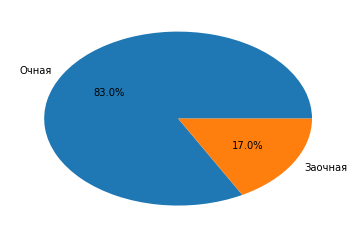

In [9]:
plt.pie(data['Форма_обучения'].value_counts(), labels=['Очная', 'Заочная'], autopct='%1.1f%%');
data['Форма_обучения'].describe()


In [ ]:
plt.figure(figsize=(40,10))
plt.xticks(rotation=90)
sns.countplot(data=data, x='Специальность', 
              order=data.Специальность.value_counts().index);


In [ ]:
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
sns.countplot(data=data, x='Подразделение', 
              order=data.Подразделение.value_counts().index);


In [ ]:
data.describe(include=['float'])


In [ ]:
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
sns.countplot(data=data, x='Филиал', 
              order=data.Филиал.value_counts().index);


In [ ]:
sns.set(font_scale=2.5)
plt.figure(figsize=(40,30))
corr_matrix=data.corr()
sns.heatmap(corr_matrix,annot=True,fmt = ".2f",cbar = True,cmap='PuOr',annot_kws={"size":18})


KeyError: 'Вид возмещения затрат'

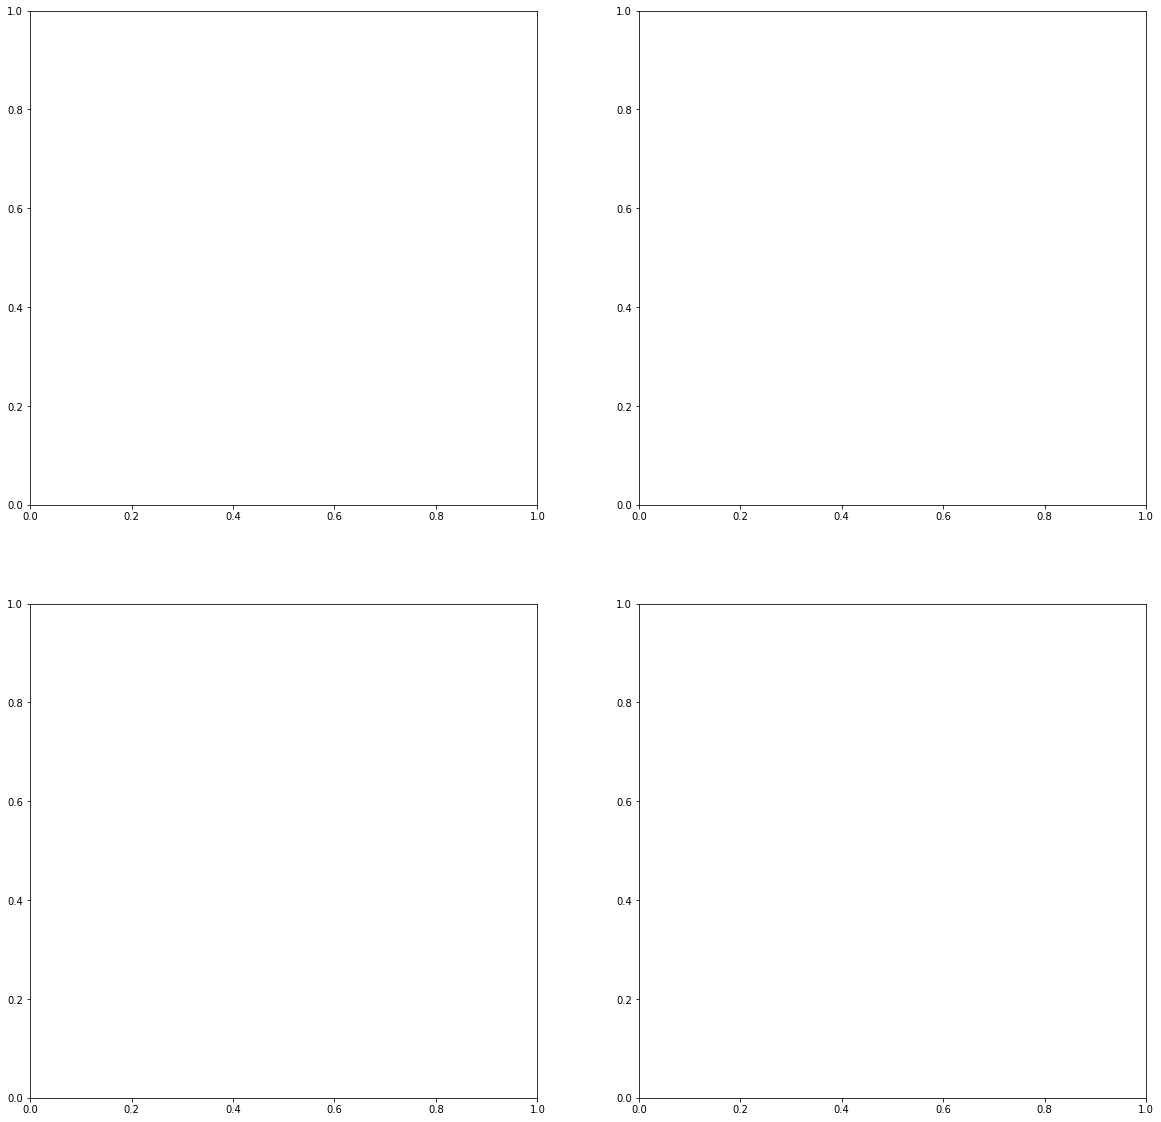

In [8]:
feats = ['Вид возмещения затрат', 'Форма обучения', 'Нуждается в общежитии']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
idx = 0
for i in range(2): 
    for j in range(2):
        sns.countplot(data[feats[idx]], ax=axes[i][j]); 
        idx += 1

In [ ]:
persons = pd.read_excel('persons.xlsx', index_col=0)
persons.head(3)

In [ ]:
feats = ['Пол', 'Иностранный язык', 'Иностранное гражданство']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(17,12))
idx = 0
for i in range(2): 
    for j in range(2):
        sns.countplot(persons[feats[idx]], ax=axes[i][j]); 
        idx += 1

In [ ]:
plt.figure(figsize=(40,10))
plt.xticks(rotation=90)
sns.countplot(data=persons, x='Пол', 
              order=persons.Пол.value_counts().index);

In [ ]:
data.isnull().any()


In [ ]:
data['Специальность'].unique()
data.Специальность.value_counts()



In [ ]:
plt.figure(figsize=(40,10))
plt.xticks(rotation=90)
sns.countplot(data=persons, x='Пол', 
              order=persons.Пол.value_counts().index);




In [ ]:
plt.figure(figsize=(12,12))
ax = sns.countplot(persons['Иностранный язык'])

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(80,20))
ax = sns.countplot(persons['Полученное образование'])

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
persons.describe(include=['object'])



In [ ]:
persons.describe()

In [ ]:
data[['Специальность']].describe()


In [ ]:
data.dropna(inplace = True)  
perc =[.20, .40, .60, .80] 
include =['object', 'float', 'int'] 
desc = data.describe() 
  

In [ ]:
plt.pie(persons['Пол'].value_counts(), labels=['Мужчины', 'Женщины'], autopct='%1.1f%%');


In [ ]:
data['Вид возмещения затрат'].describe()


In [ ]:
data['Вид возмещения затрат'].unique()


In [ ]:
data.['Вид возмещения затрат'].value_counts()


In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.3)
Зададим вектор признаков и целевую переменную

Recommended IND
X_train, y_train = train.drop('Специальность', axis = 1), train['Специальность']
X_test, y_test = test.drop('Специальность', axis = 1), test['Специальность']

X_text_train = X_train['Подразделение']
X_text_test = X_test['Подразделение']
cv = CountVectorizer()
cv.fit(X_text_train)
​
len(cv.vocabulary_)
12167
Закодируем предложения из текстов обучающей выборки индексами входящих слов. Используем разреженный формат.

X_text_train_cv = cv.transform(X_text_train)
Преобразуем так же тестовую выборку.

X_text_test_cv = cv.transform(X_text_test)
Обучим логистическую регрессию на данных отзывов
Обучим логистическую регрессию на данных отзывов
%%time
logit = LogisticRegression(n_jobs=-1, random_state=7)
logit.fit(X_text_train_cv, y_train)
%%time
logit = LogisticRegression(n_jobs=-1, random_state=7)
logit.fit(X_text_train_cv, y_train)
Обучим LinearSVC
Обучим LinearSVC
%%time
svm = LinearSVC(random_state=7)
svm.fit(X_text_train_cv, y_train)
%%time
svm = LinearSVC(random_state=7)
svm.fit(X_text_train_cv, y_train)
Wall time: 3.16 s
8. Кросс-валидация и настройка гиперпараметров модели
%%time
from sklearn.pipeline import make_pipeline

text_pipe_logit = make_pipeline(CountVectorizer(), 
                                LogisticRegression(n_jobs=-1, random_state=7))

text_pipe_logit.fit(X_text_train, y_train)
%%time
from sklearn.pipeline import make_pipeline
​
text_pipe_logit = make_pipeline(CountVectorizer(), 
                                LogisticRegression(n_jobs=-1, random_state=7))
​
text_pipe_logit.fit(X_text_train, y_train)
C:\Users\Rub\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
Wall time: 3.03 s
%%time
from sklearn.model_selection import GridSearchCV

param_grid_logit = {'logisticregression__C': 
                    np.logspace(-5, 0, 6)}
grid_logit = GridSearchCV(text_pipe_logit, param_grid_logit, cv=3, n_jobs=-1)

%%time
from sklearn.model_selection import GridSearchCV
​
param_grid_logit = {'logisticregression__C': 
                    np.logspace(-5, 0, 6)}
grid_logit = GridSearchCV(text_pipe_logit, param_grid_logit, cv=3, n_jobs=-1)
​
grid_logit.fit(X_text_train, y_train)
C:\Users\Rub\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
Wall time: 52.7 s
Лучшее значение C и соответствующее качество на кросс-валидации.

grid_logit.best_params_, grid_logit.best_score_
({'logisticregression__C': 0.1}, 0.8875304136253042)
То же самое для LinearSVC.

%%time
text_pipe_svm = make_pipeline(CountVectorizer(), LinearSVC(random_state=7))
​
text_pipe_svm.fit(X_text_train, y_train)
print(text_pipe_svm.score(X_text_test, y_test))
0.8773772353108147
Wall time: 5.01 s
%%time
param_grid_svm = {'linearsvc__C': np.logspace(-5, 0, 6)}
grid_svm = GridSearchCV(text_pipe_svm, param_grid_svm, cv=3, n_jobs=-1)
​
grid_svm.fit(X_text_train, y_train);
Wall time: 24.4 s
grid_svm.best_params_, grid_svm.best_score_
({'linearsvc__C': 0.01}, 0.8882603406326034)
## 10. Построение кривых валидации и обучения
## 10. Построение кривых валидации и обучения
def plot_grid_scores(grid, param_name):
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_train_score'],
        color='green', label='train')
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_test_score'],
        color='red', label='test')
    plt.legend();
def plot_grid_scores(grid, param_name):
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_train_score'],
        color='green', label='train')
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_test_score'],
        color='red', label='test')
    plt.legend();
plot_grid_scores(grid_logit, 'logisticregression__C')
C:\Users\Rub\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)

grid_svm.best_params_, grid_svm.best_score_
({'linearsvc__C': 0.01}, 0.8882603406326034)
plot_grid_scores(grid_svm, 'linearsvc__C')
C:\Users\Rub\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)

## 11. Прогноз для тестовой или отложенной выборки
%%time
logit = LogisticRegression(C = 0.1, n_jobs=-1, random_state=7)
logit.fit(X_text_train_cv, y_train)
logit_pred = logit.predict(X_text_test_cv)
​
a = round(recall_score(y_test, logit_pred), 5)
b = round(precision_score(y_test, logit_pred), 5)
c = round(f1_score(y_test, logit_pred), 5)
​
print('Recall score :', a, 'Precision score:', b, 'F1 score:', c)
C:\Users\Rub\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
Recall score : 0.95798 Precision score: 0.91059 F1 score: 0.93368
Wall time: 1.26 s
%%time
svm = LinearSVC(C = 0.01, random_state=7)
svm.fit(X_text_train_cv, y_train)
svm_pred = svm.predict(X_text_test_cv)

a = round(recall_score(y_test, svm_pred), 5)
b = round(precision_score(y_test, svm_pred), 5)
c = round(f1_score(y_test, svm_pred), 5)

print('Recall score :', a, 'Precision score:', b, 'F1 score:', c)
%%time
svm = LinearSVC(C = 0.01, random_state=7)
svm.fit(X_text_train_cv, y_train)
svm_pred = svm.predict(X_text_test_cv)
​
a = round(recall_score(y_test, svm_pred), 5)
b = round(precision_score(y_test, svm_pred), 5)
c = round(f1_score(y_test, svm_pred), 5)
​
print('Recall score :', a, 'Precision score:', b, 'F1 score:', c)
Recall score : 0.95798 Precision score: 0.91163 F1 score: 0.93423
Wall time: 409 ms

ValueError: could not convert string to float: 'бюджет'

In [26]:
pd.factorize(data['Вид возмещения затрат'])[0]

array([0, 0, 1, ..., 0, 0, 1], dtype=int64)

count      47132
unique         2
top       бюджет
freq       23990
Name: Возмещения_затрат, dtype: object

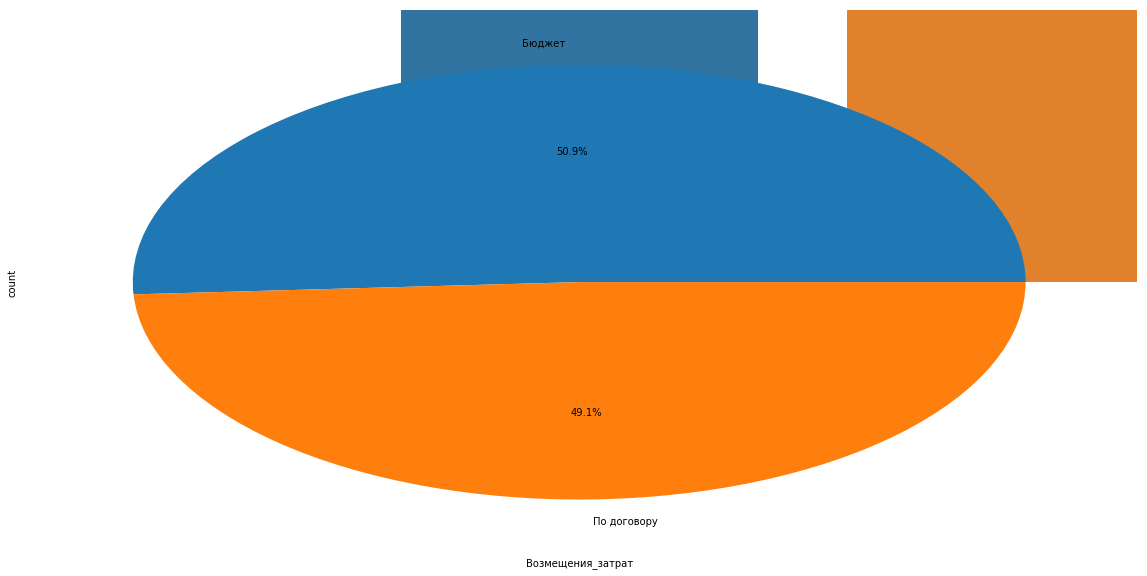

In [10]:
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
sns.countplot(data=data, x='Возмещения_затрат', 
              order=data.Возмещения_затрат.value_counts().index);


In [32]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 47281 entries, 1 to 14193
Data columns (total 35 columns):
Пол                           47281 non-null object
Нуждается_в_общежитии         15248 non-null object
Дата_подачи                   47132 non-null object
Вид_заявления                 47132 non-null object
Возмещения_затрат             47132 non-null object
Форма_обучения                47132 non-null object
Вид_приема                    47132 non-null object
Филиал                        47132 non-null object
Подразделение                 47132 non-null object
Специальность                 47132 non-null object
Набор ОП                      47132 non-null object
Сроки освоения                47132 non-null object
Согласие на зачисление        9996 non-null object
Состояние выбран. конкурса    47131 non-null object
Документы                     47132 non-null object
Сумма баллов                  47098 non-null float64
Итоговая сумма баллов         28652 non-null object
Приорит

count      47132
unique         2
top       бюджет
freq       23990
Name: Возмещения_затрат, dtype: object

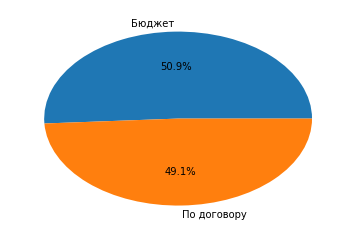

In [11]:
plt.pie(data['Возмещения_затрат'].value_counts(), labels=['Бюджет', 'По договору'], autopct='%1.1f%%');
data['Возмещения_затрат'].describe()


In [35]:
data['Возмещения_затрат'] = data.Возмещения_затрат.astype(int)
                                                      


ValueError: invalid literal for int() with base 10: 'бюджет'

In [36]:
object_category = list(data.dtypes.loc[data.dtypes == 'object'].index)
print(object_category)

['Пол', 'Нуждается_в_общежитии', 'Дата_подачи', 'Вид_заявления', 'Возмещения_затрат', 'Форма_обучения', 'Вид_приема', 'Филиал', 'Подразделение', 'Специальность', 'Набор ОП', 'Сроки освоения', 'Согласие на зачисление', 'Состояние выбран. конкурса', 'Документы', 'Итоговая сумма баллов', 'Статус результатов ЕГЭ', 'Индивидуальные достижения', 'Приказ о зачислении']


In [61]:
data['Дата_подачи'].replace('', np.nan, inplace=True)
data.dropna(subset=['Дата_подачи'], inplace=True)
data['Вид_заявления'].replace('', np.nan, inplace=True)
data.dropna(subset=['Вид_заявления'], inplace=True)
data['Возмещения_затрат'].replace('', np.nan, inplace=True)
data.dropna(subset=['Возмещения_затрат'], inplace=True)
data['Форма_обучения'].replace('', np.nan, inplace=True)
data.dropna(subset=['Форма_обучения'], inplace=True)
data['Вид_приема'].replace('', np.nan, inplace=True)
data.dropna(subset=['Вид_приема'], inplace=True)
data['Филиал'].replace('', np.nan, inplace=True)
data.dropna(subset=['Филиал'], inplace=True)
data['Подразделение'].replace('', np.nan, inplace=True)
data.dropna(subset=['Подразделение'], inplace=True)
data['Специальность'].replace('', np.nan, inplace=True)
data.dropna(subset=['Специальность'], inplace=True)
data['Набор ОП'].replace('', np.nan, inplace=True)
data.dropna(subset=['Набор ОП'], inplace=True)
data['Сроки освоения'].replace('', np.nan, inplace=True)
data.dropna(subset=['Сроки освоения'], inplace=True)
data['Согласие на зачисление'].replace('', np.nan, inplace=True)
data.dropna(subset=['Согласие на зачисление'], inplace=True)
data['Состояние выбран. конкурса'].replace('', np.nan, inplace=True)
data.dropna(subset=['Состояние выбран. конкурса'], inplace=True)
data['Итоговая сумма баллов'].replace('', np.nan, inplace=True)
data.dropna(subset=['Итоговая сумма баллов'], inplace=True)

In [54]:
df1 = data.replace(np.nan, '', regex=True) 

In [53]:
data['Дата_подачи', 'Вид_заявления', ].replace('', np.nan, inplace=True)
data.dropna(subset=['Дата_подачи', 'Вид_заявления'], inplace=True)

KeyError: ('Дата_подачи', 'Вид_заявления')

In [62]:
le = LabelEncoder()
for var in object_category:
    data[var] = le.fit_transform(data[var])
for var in object_category[:-1]:
    test[var] = le.fit_transform(test[var])

TypeError: argument must be a string or number

In [63]:
data.head()

,Пол,Нуждается_в_общежитии,Дата_подачи,Вид_заявления,Возмещения_затрат,Форма_обучения,Вид_приема,Филиал,Подразделение,Специальность,...,Ая,Ня,Фя,О,Л,Ия,И,Статус результатов ЕГЭ,Индивидуальные достижения,Приказ о зачислении
№,,,,,,,,,,,,,,,,,,,,,
16,0,0,6,0,0,1,0,1,5,45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,1,0,63,0,0,1,1,1,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Ря 65, зачтен, ФИС - Проверен. Действующий, 20...",NaN,NaN
26,0,0,40,1,0,1,1,1,5,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4118 о/п от 23.08.2017
27,1,0,29,0,0,1,1,1,6,28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3975 о/п от 08.08.2017
47,1,0,63,0,0,1,1,1,0,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Ря 57, зачтен, ФИС - Проверен. Действующий, 20...",NaN,NaN


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002F992DE10F0>,
      dtype=object)

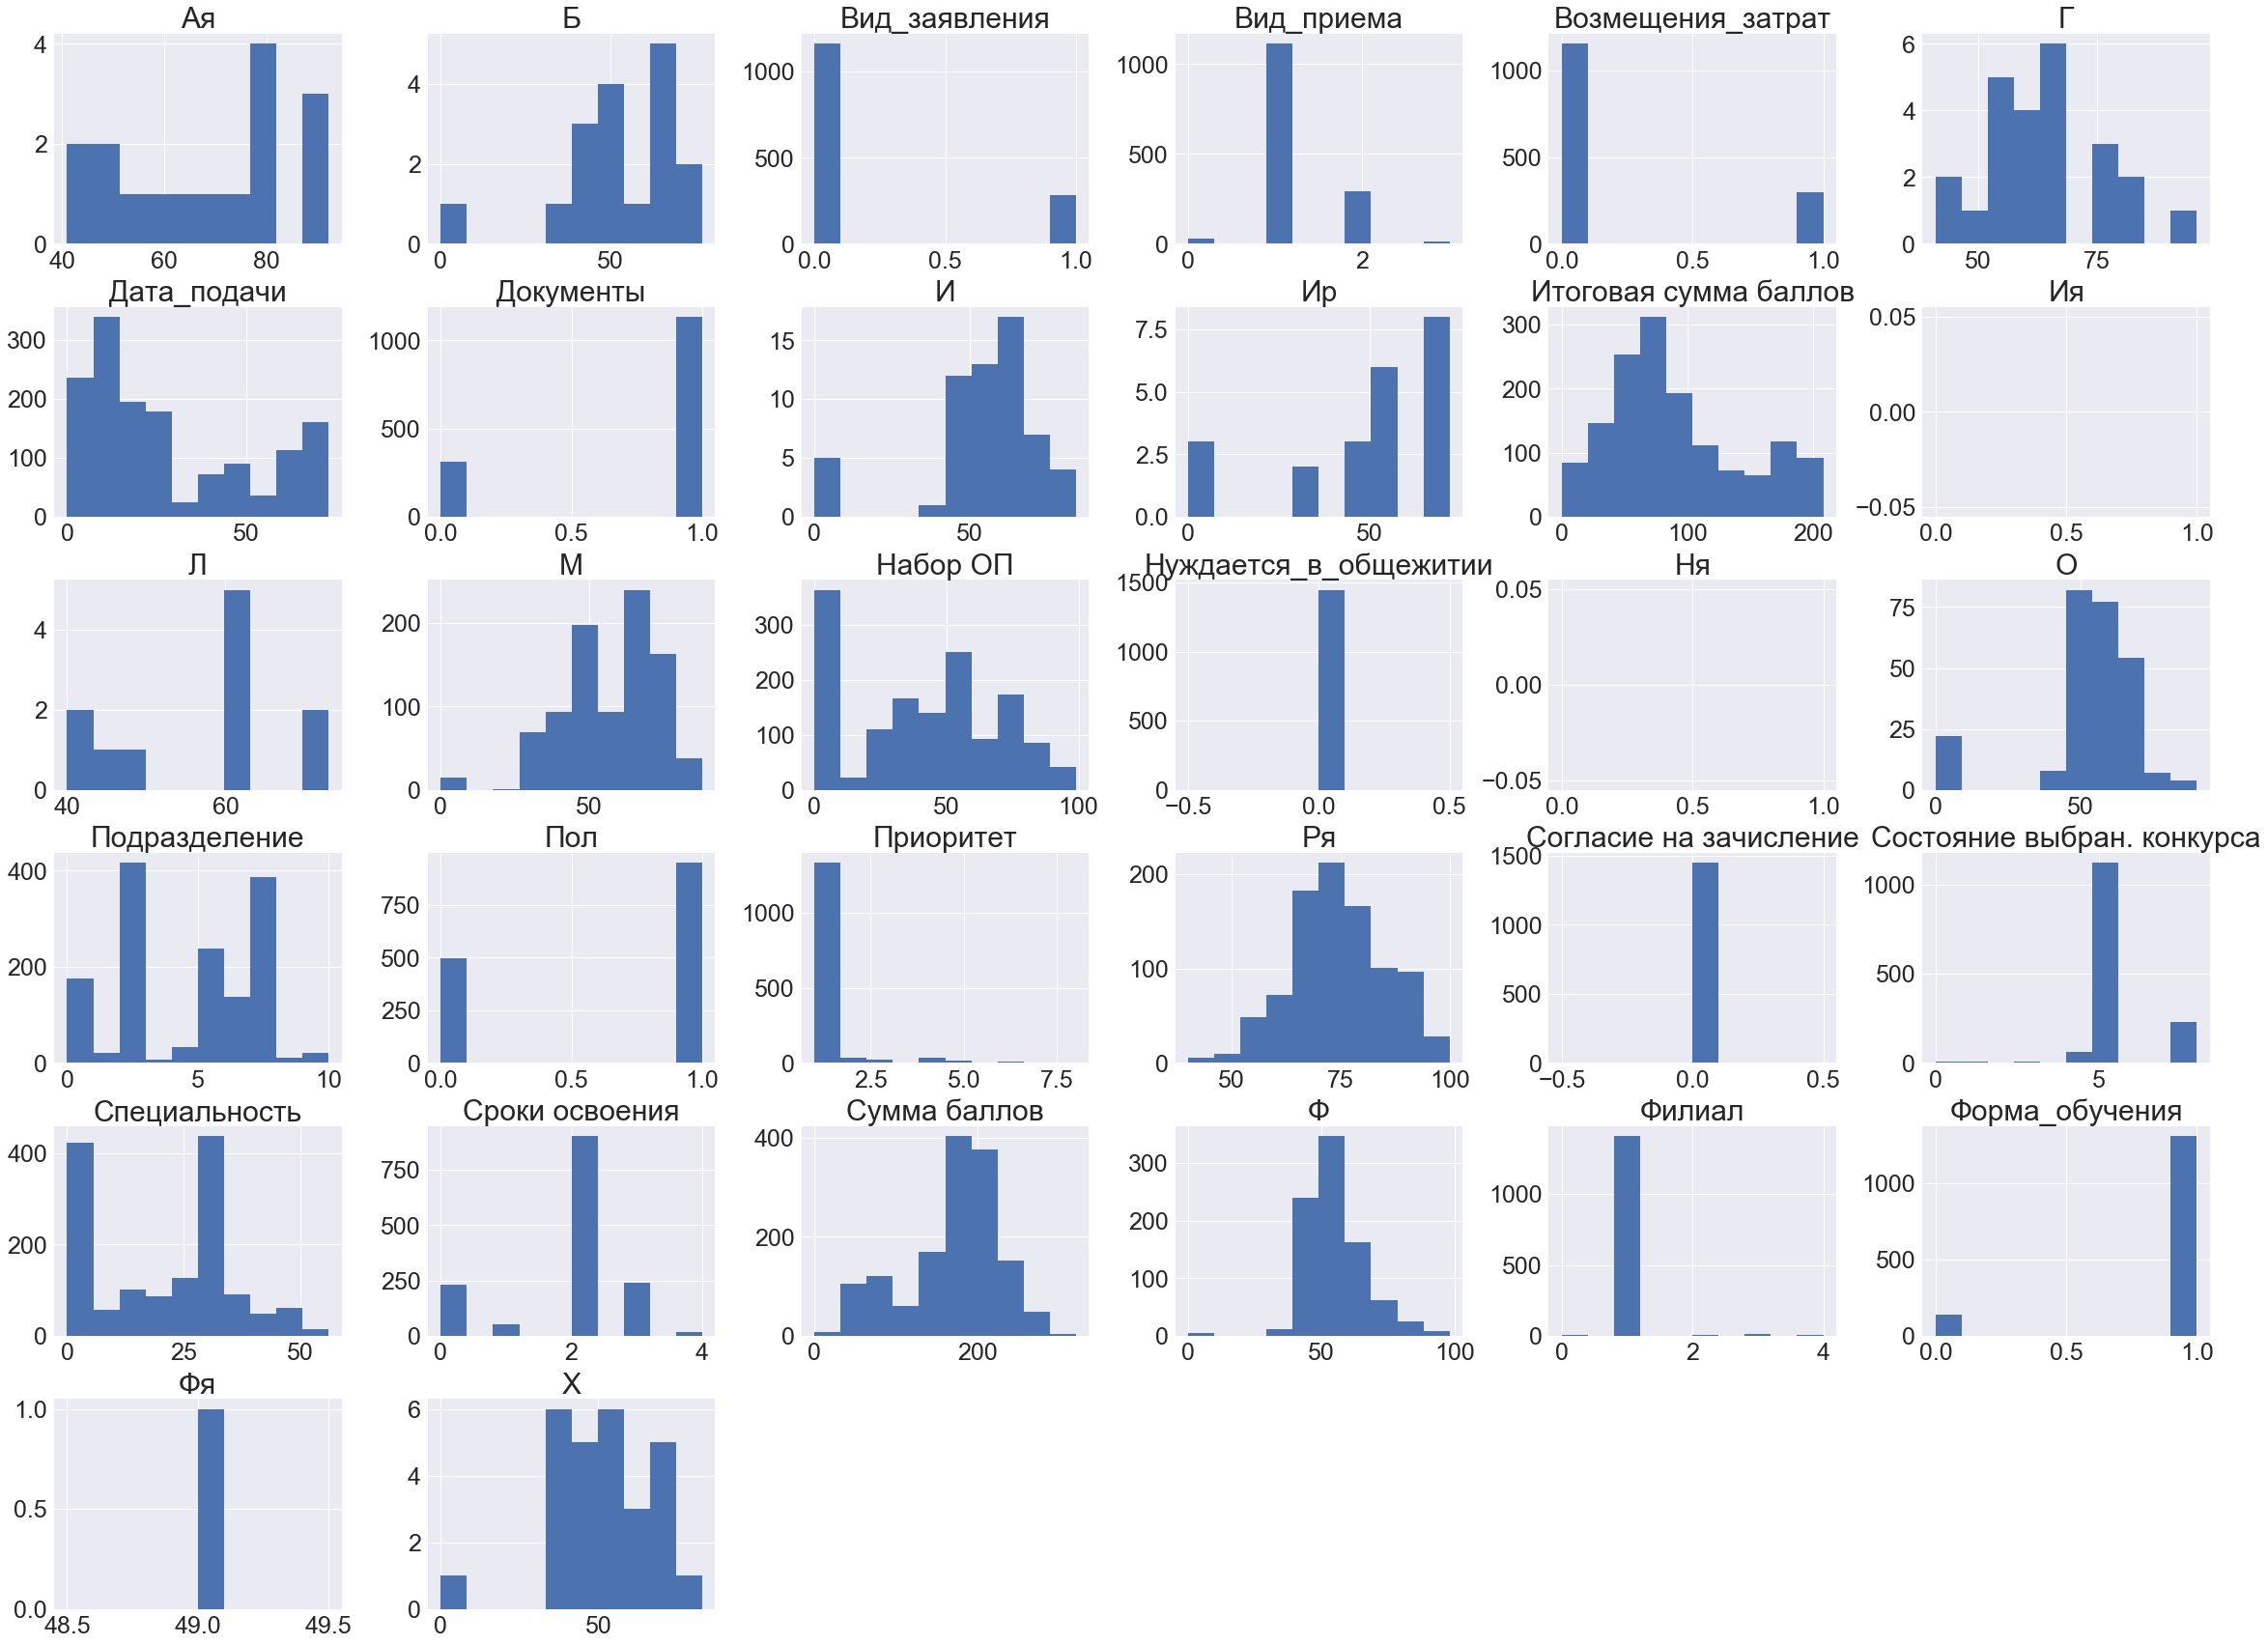

In [64]:
data.hist(figsize=(40, 30))


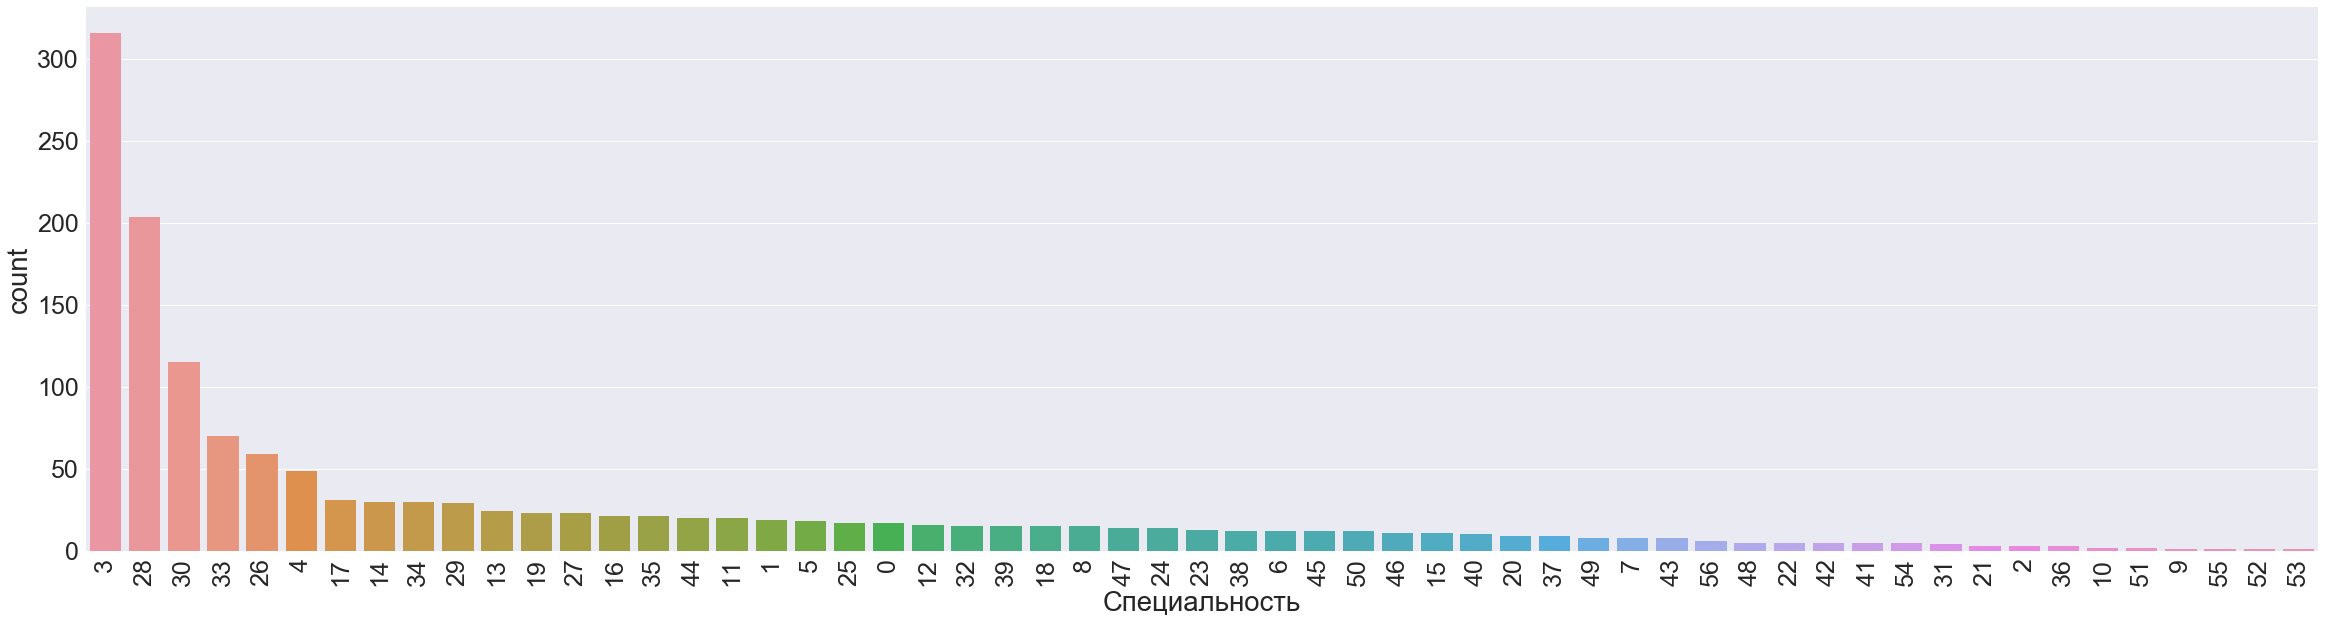

In [89]:
plt.figure(figsize=(40,10))
plt.xticks(rotation=90)
sns.countplot(data=data, x='Специальность', 
              order=data.Специальность.value_counts().index);

In [71]:
def plot_distribution(df, var, target, yl=4, **kwargs):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(df, hue=target, aspect=4, row=row, col=col)
    facet.map(sns.kdeplot, var, shade=True)
    facet.set(xlim=(0, df[var].max()), ylim=(0, yl))
    facet.add_legend()
    plt.show()

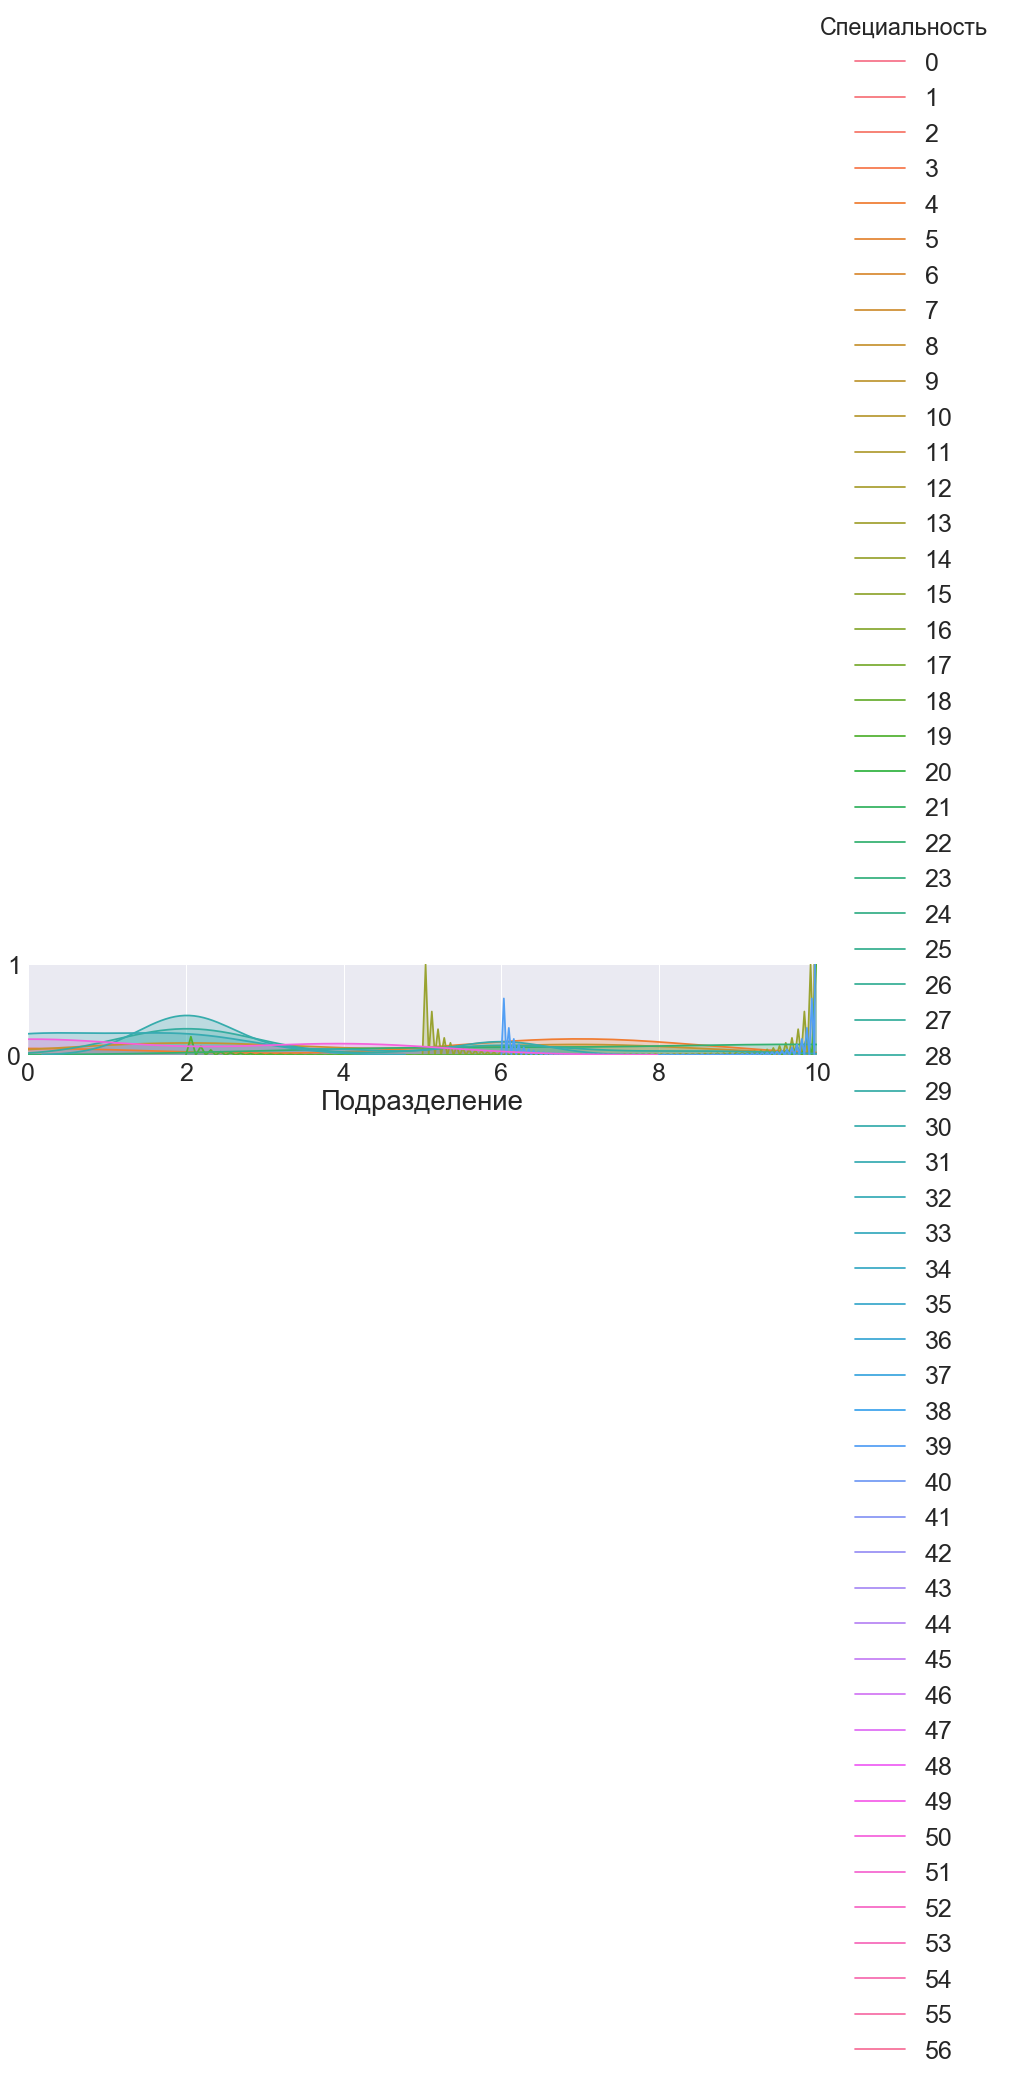

In [96]:
plot_distribution(data, 'Подразделение','Специальность', 1)

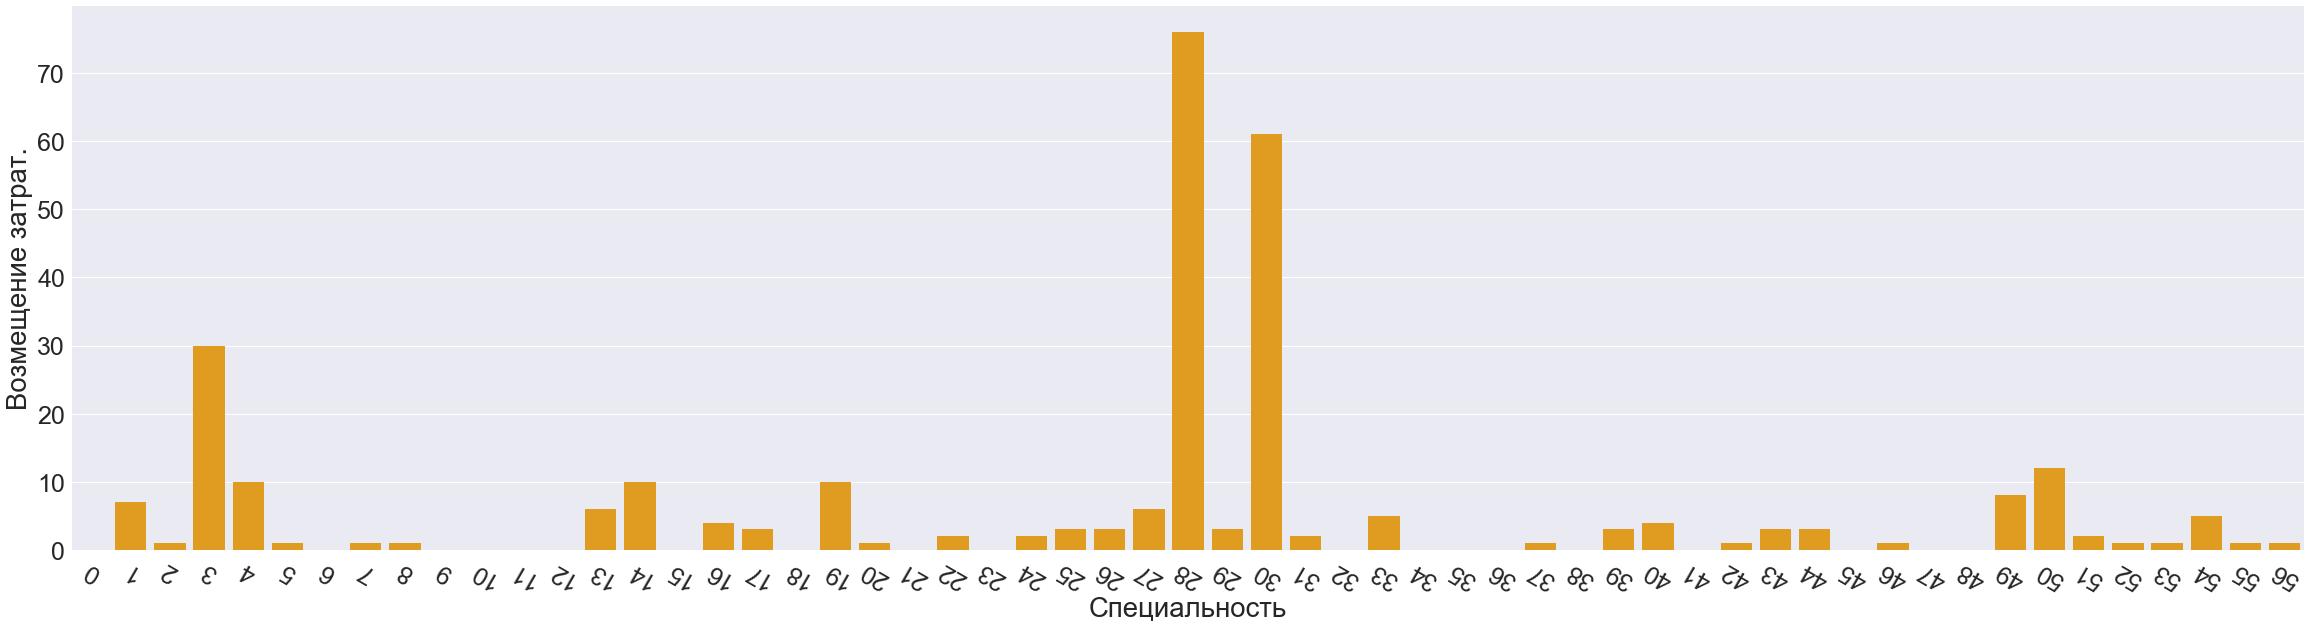

In [88]:
pvt = data.pivot_table(columns=['Специальность'], values='Возмещения_затрат', aggfunc='sum')
plt.figure(figsize=(40,10))
plt.xticks(rotation=150)
sns.barplot(pvt.columns.values, pvt.values[0], color='Orange', palette=None,)
plt.xlabel('Специальность')
plt.ylabel('Возмещение затрат.')
plt.show()